## Table des matières :
* [I - Mise en place de l'environnement de travail](#first)
    * [1 - Récupération des données](#first_1)
    * [2 - Étude des corrélations entre features et price](#first_2)
* [II - Entraînement du modèle](#second)
    * [1 - Création Regression lineaire](#second_1)
    * [2 - Création Random Forest](#second_2)
        * [2.1 - Données de mai à octobre 2014](#second_2_1)
        * [2.2 - Données de mai 2014 à février 2015](#second_2_2)
* [III - Simulation](#third)
    * [1 - Utils](#third_1)
    * [2 - Affichage performance du modèle](#third_2_1)
        * [2.1 - RF1 : Novembre 2014 -> Mai 2015 ](#third_2_2)
        * [2.2 - RF2 : Mars 2015 -> Mai 2015 ](#third_2_2)

# I - Mise en place de l'environnement de travail <a class="anchor" id="first"></a>

In [1]:
import numpy as np
import pandas as pd
import tempfile
temp_dir = tempfile.TemporaryDirectory()
import os
import requests
import json
import time
import matplotlib.pyplot as plt
import datetime as dt

# MLFlow : https://mlflow.org/
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from __future__ import division
from scipy.stats import pearsonr

from dateutil.relativedelta import *
from pandas.tseries.offsets import MonthEnd

## 1 - Récupération des données <a class="anchor" id="first_1"></a>


In [3]:
# import dataset
# https://raw.githubusercontent.com/rashida048/Datasets/master/home_data.csv

df = pd.read_csv('../data/flat_data.csv')

# on convertit en datetime notre colonne de date
df["date"] = pd.to_datetime(df["date"])
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,coef_ajustement
0,5561000190,2014-05-02,4.375000e+05,3,2.25,1970,35100,2.0,0,0,...,1970,0,1977,0,98027,47.4635,-121.991,2340,35100,1.000000
1,472000620,2014-05-02,7.900000e+05,3,2.50,2600,4750,1.0,0,0,...,1700,900,1951,0,98117,47.6833,-122.400,2380,4750,1.000000
2,1024069009,2014-05-02,6.750000e+05,5,2.50,2820,67518,2.0,0,0,...,2820,0,1979,0,98029,47.5794,-122.025,2820,48351,1.000000
3,7853361370,2014-05-02,5.550000e+05,4,2.50,3310,6500,2.0,0,0,...,3310,0,2012,0,98065,47.5150,-121.870,2380,5000,1.000000
4,5056500260,2014-05-02,4.400000e+05,4,2.25,2160,8119,1.0,0,0,...,1080,1080,1966,0,98006,47.5443,-122.177,1850,9000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,1422700040,2015-05-14,2.102280e+05,3,1.00,1170,7320,1.0,0,0,...,1170,0,1962,0,98188,47.4685,-122.282,2040,7320,1.148787
21609,8730000270,2015-05-14,4.124146e+05,2,2.75,1370,1140,2.0,0,0,...,1080,290,2009,0,98133,47.7052,-122.343,1370,1090,1.148787
21610,7923600250,2015-05-15,5.171361e+05,5,2.00,1870,7344,1.5,0,0,...,1870,0,1960,0,98007,47.5951,-122.144,1870,7650,1.149191
21611,5101400871,2015-05-24,5.121449e+05,2,1.75,1390,6670,1.0,0,0,...,720,670,1941,0,98115,47.6914,-122.308,920,6380,1.149596


199.875944136534 -146437062.57987693


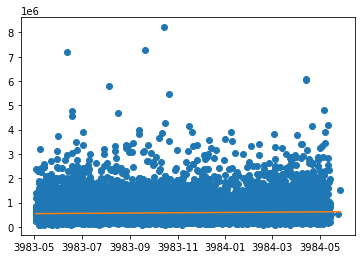

In [4]:
# on trace la régréssion linéaire entre le prix et la date (ordinale)
(a, b) = np.polyfit(df["date"].map(dt.datetime.toordinal), df['price'], 1)

# on affiche les coefficients de regression
print(a, b)

plt.plot_date(df["date"].map(dt.datetime.toordinal), df['price'], fmt='o', tz=None, xdate=True, ydate=False)
plt.plot(df["date"].map(dt.datetime.toordinal), df["date"].map(dt.datetime.toordinal)* a+b)
# on observe qu'il y a une augmentation du prix moyen de vente en fonction du temps

## 2 - Étude des corrélations entre features et price <a class="anchor" id="first_2"></a>


In [5]:
features, target = df.iloc[:, 3:].columns.tolist(), df['price']

correlations = {f'{feature} vs {target.name}': pearsonr(df[feature], target)[0] for feature in features}

df_correlations = pd.DataFrame(correlations, index=['Value']).T
df_correlations.loc[df_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.697072
grade vs price,0.662982
sqft_above vs price,0.601451
sqft_living15 vs price,0.581688
bathrooms vs price,0.521281
view vs price,0.395809
sqft_basement vs price,0.321219
bedrooms vs price,0.306284
lat vs price,0.305024
waterfront vs price,0.265865


# II - Entraînement du modèle <a class="anchor" id="second"></a>

Fonctions utiles pour extraction et évaluation

In [6]:
# Fonction pour évaluer nos prédictions

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


# Fonction qui nous renvoit un subset des 12 features (X) et de la target price (Y)
# à partir du dataset ajusté sur un interval entre deux dates

def extract_interval(start_date,end_date):
    try:
        # on filtre sur notre interval de date
        mask = (df['date'] >= start_date) & (df['date'] <= end_date)
        data_prep = df.loc[mask]
    
    except Exception as ex:
        print(ex)
        raise print("mauvais format de dates, attendu AAAA-MM-JJ")
    x = df_prep[['view',
                 'lat',
                 'waterfront',
                 'bedrooms',
                 'bathrooms',
                 'sqft_basement',
                 'sqft_above',
                 'sqft_living',
                 'sqft_living15',
                 'floors',
                 'grade',
                 'yr_built']]
    Y = df['price']
    return x, Y

# Fonction qui va nous permettre de retourner le nom du modèle
# à partir de son instance

def get_model_name(model_instance):
    raw_model_name = type(model_instance).__name__
    # split uppercase (LinearRegression -> Linear Regression)
    model_name = ''.join(' '+letter if letter.isupper() else letter for letter in raw_model_name).strip()
    return model_name



## 1 - Création Regression lineaire <a class="anchor" id="second_1"></a>

In [34]:
# On entraine puis test notre modèle de Mai à Décembre
start_date = '2014-05-01'
end_date = "2014-12-01"
x, Y = extract_interval(start_date, end_date)

# Séparation du dataset en training et testing sets
SEED = 42
TEST_SIZE = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=TEST_SIZE, random_state=SEED)

# On indique quelle expérience, nous voulons créer/utiliser
mlflow.set_experiment("princing_prediction")

with mlflow.start_run():

    regLin = LinearRegression()
    regLin.fit(x_train, y_train)
    predicted_prices = regLin.predict(x_test)
    (rmse,mae,r2) = eval_metrics(y_test, predicted_prices)

    print("model trained with date interval", start_date, '->', end_date)
    print("number of row trained", len(y_train))
    print("number of row tested", len(y_test), "\n")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    #log param and metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    #set tag
    model_name = get_model_name(regLin) # Get model name
    mlflow.set_tag("mlflow.note.content", f"{model_name}\nTraining period : {start_date} to {end_date}")

    #log artifact
    #log model
    mlflow.sklearn.log_model(regLin, "model")

    mlflow.end_run()


INFO: 'adil_pricing_prediction' does not exist. Creating a new experiment
model trained with date interval 2014-05-01 -> 2014-12-01
number of row trained 10606
number of row tested 2652 

  RMSE: 213603.87397952858
  MAE: 132465.6878987938
  R2: 0.6726032190766915


## 2 - Création Random Forest <a class="anchor" id="second_2"></a>

### 2.1 - Données de mai à octobre 2014 <a class="anchor" id="second_2_1"></a>

In [8]:
# on entraine puis test notre modèle de Mai à Octobre
start_date = '2014-05-01'
end_date = "2014-10-01"
x,Y = extract_interval(start_date, end_date)
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.20, random_state=42)

# n_estimators=150
# on indique quelle expérience, nous voulons créer/utiliser
# mlflow.set_experiment("mon_expérience")

# Define model hyperparameters
#random_forest_regressor_params = {'n_estimators': 150}

with mlflow.start_run():

    regRF = RandomForestRegressor(**random_forest_regressor_params)
    regRF.fit(x_train, y_train)
   
    predicted_prices = regRF.predict(x_test)
    # Get evaluated metrics
    metric_results = eval_metrics(y_test, predicted_prices)
    print("model trained with date interval", start_date, '->', end_date)
    print("number of row trained", len(y_train))
    print("number of row tested", len(y_test), "\n")
    
    
    # enregistrer avec mlflow :
    #   - params
    #   - metrics
    #   - model
    #   - artifact(dataset de training)
    #   - tag (notes) : décrire sur quelle période le modèle a été entrainé

    # https://www.mlflow.org/docs/latest/python_api/mlflow.sklearn.html#mlflow.sklearn.log_model
    # exemple pour param et metrics
    # 
    # mlflow.log_param("param", exemple_param)
    # mlflow.log_metric("precision", exemple_predicision)
    
   
    
    
    mlflow.end_run()


model trained with date interval 2014-05-01 -> 2014-10-01
number of row trained 7967
number of row tested 1992 

RMSE = 169998.10180369
MAE = 87943.39802146913
R2 = 0.7958857508690024


### 2.2 - Données de mai 2014 à février 2015 <a class="anchor" id="second_2_2"></a>

In [10]:
# on entraine puis test notre modèle sur une plus grande période
start_date = '2014-05-01'
end_date = "2015-02-01"
x, Y = extract_interval(start_date,end_date)
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.20, random_state=42)

# on indique quelle expérience, nous voulons créer/utiliser
# mlflow.set_experiment("mon_expérience")

# Define model hyperparameters
#random_forest_regressor_params = {'n_estimators': 150}


with mlflow.start_run():

    regRF = RandomForestRegressor(**random_forest_regressor_params)
    regRF.fit(x_train, y_train)
   
    predicted_prices = regRF.predict(x_test)
    # Get evaluated metrics
    metric_results = eval_metrics(y_test,predicted_prices)
    print("model trained with date interval",start_date,'->',end_date)
    print("number of row trained",len(y_train))
    print("number of row tested",len(y_test),"\n")
        
    # enregistre avec mlflow :
    #   - params
    #   - metrics
    #   - model
    #   - artifact(dataset de training)
    #   - tag (notes) : décrire sur quelle période le modèle a été entrainé

    mlflow.end_run()

model trained with date interval 2014-05-01 -> 2015-02-01
number of row trained 12490
number of row tested 3123 

RMSE = 157661.07016356313
MAE = 86684.4444559148
R2 = 0.8244470355163681


# III - Simulation <a class="anchor" id="third"></a>

 ## 1 - Utils  <a class="anchor" id="third_1"></a>


In [ ]:
# Nous allons simuler des prédictions puis nous allons calculer et afficher les performances de nos modèles

# créons notre fonction de prédiction
# cette fonction va faire un appel unitaire à l'API avec une requete POST

# exemple payload
# payload = {
#    "view" : 0,
#    "lat": 47.4639,
#    "waterfront": 0,
#    "bedrooms": 3,
#    "bathrooms": 2.5,
#    "sqft_basement": 0,
#    "sqft_above": 3970,
#    "sqft_living": 3970,
#    "sqft_living15": 5340,
#    "floors":7,
#    "grade":7,
#    "yr_built": 1973
# }

# def predict_price(features_data, api_type='stream'):
#     # payload est un JSON 
#     url = f"http://api:8000/{api_type}"
#     headers = {'Content-Type': 'text/plain'}
#     payloads = features_data if type(features_data) in (list, tuple) else json.dumps(features_data)
#     response = requests.request("POST", url, headers=headers, data=payloads)
#     return json.loads(response.text)


def predict_price_stream(payload):
    # payload est un JSON 
    url = "http://api:8000/stream"

    headers = {
    'Content-Type': 'text/plain'
    }
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
    return response.text

def predict_price_batch(payloads):
    # payload est un JSON 
    url = "http://api:8000/batch"

    headers = {
    'Content-Type': 'text/plain'
    }
    response = requests.request("POST", url, headers=headers, data=payloads)
    return json.loads(response.text)

In [2]:
# On va tester notre modèle sur chaque mois à partir du start_date 
# pour assurer la stabilité des résultats nous lissons les performances sur 2 mois glissants

def display_results(start_date, end_date, r2_threshold=0.78): 
    r2_tab = [] 
    rmse_tab = [] 
    date_tab = [] 
    start_date = pd.to_datetime(start_date) + relativedelta(months=1)
    start_date = start_date.strftime("%Y-%m-%d")
    for beg in pd.date_range(start_date, end_date, freq='MS'): 
        # on lisse notre résultat sur 2 mois glissants 
        start = pd.to_datetime(beg) - relativedelta(months=1) 
        end = beg + MonthEnd(0) 
        (x, Y) = extract_interval(start, end)
        print(start.strftime("%Y-%m-%d"),"-->", end.strftime("%Y-%m-%d"), 'nbr_pred', len(Y)) 
        batch_records = x.to_json(orient="records")
        predicted_prices = predict_price_batch(batch_records)
        (rmse, mae, r2) = eval_metrics(Y, predicted_prices)
        r2_tab.append(r2)
        rmse_tab.append(rmse)
        date_tab.append(beg.strftime("%Y-%m-%d"))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)
    # affichage graphique 
    fig, r2_axe = plt.subplots(figsize=(10, 5)) 
    # titre du graphique  
    plt.title('evolution des metrics en fonction du temps')
    # using the twinx() for creating another 
    # axes object for secondry y-Axis 
    rmse_axe = r2_axe.twinx() 
    r2_axe.plot(date_tab, r2_tab, color='g', label="R2") 
    rmse_axe.plot(date_tab, rmse_tab, color='b', label="RSME") 
    r2_axe.set_xlabel('Date')
    rmse_axe.set_ylabel('RSME', color="b")
    r2_axe.set_ylabel('R2', color='g')
    r2_axe.axhline(y=r2_threshold, color='gray', linestyle='--')
    # Définition des bornes des intervalles des métriques
    rmse_axe.set_ylim(100000, 250000)
    r2_axe.set_ylim(0.7, 0.85)
    # defining display layout
    fig.legend()
    plt.show()

## 2 - Affichage performance du modèle <a class="anchor" id="third_2"></a>

### 2.1 - RF1 : Novembre 2014 -> Mai 2015 <a class="anchor" id="third_2_1"></a>

In [ ]:
# On fait notre première observation avec un modèle entrainé avec des données de Mai au 1 Novembre 2015
# on observe une diminution des performances à partir du mois de Février 
# (drift des données liée à une augmentation des prix en fonction du temps)
display_results("2014-11-01","2015-05-01")

### 2.2 - RF2 : Mars 2015 -> Mai 2015 <a class="anchor" id="third_2_2"></a>

In [ ]:
# Nous avons réentrainé un modèle avec des données plus récentes allant jusqu'a Février 2015.
# On voit que le nouveau modèle est beaucoup plus précis sur les mois de Mars à Mai 2015
display_results("2015-02-01", "2015-05-01")
# Nous observons alors qu'un réentrainement est encore à prévoir au mois suivant
# Cependant, les performances au mois de Mai seront toujours plus exactes que celles du modèle précédent